In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
repo_url = "https://github.com/aakashvardhan/s22-unet-vae.git"

local_dir = '/content/s22-unet-vae'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

Cloning into 's22-unet-vae'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 143 (delta 66), reused 120 (delta 43), pack-reused 0
Receiving objects: 100% (143/143), 86.64 KiB | 4.33 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [4]:
%cd s22-unet-vae

/content/s22-unet-vae


In [5]:
import sys

sys.path.append('.')
sys.path.append('./models')
sys.path.append('./data')
sys.path.append('./notebooks')
sys.path.append('./utils')

In [6]:
!pip install -q -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.9 MB/s eta 0:00:00


In [7]:
from lightning.pytorch import Trainer, seed_everything
import lightning as pl
from lightning.pytorch.callbacks import (ModelCheckpoint,
                                         LearningRateMonitor,
                                         RichModelSummary,
                                         EarlyStopping)
from config import UNetConfig, load_config, update_config
import torch
import os
from lit_unet import LitUNet
from datamodule import DataModule
from callbacks import ClassAccuracyLoss, PlotExampleCallback
import wandb
from lightning.pytorch.loggers import WandbLogger

os.environ["WANDB_NOTEBOOK_NAME"] = "./notebooks/train-unet-model-1.ipynb"
wandb.init(settings=wandb.Settings(_service_wait=300))

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
torch.cuda.empty_cache()
pl.seed_everything(42, workers=True)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [9]:
config = UNetConfig()
json_data = load_config("training_1.json")
config = update_config(config, json_data)
print(config)

UNetConfig(in_channels=3, out_channels=3, num_filters=64, num_layers=4, batch_size=16, learning_rate=0.001, epochs=25, root_dir='./data', height=240, width=240, optimizer='adam', loss_function='cross_entropy', channel_reduction_method='max_pool', channel_expansion_method='conv_transpose', softmax_dim=1, dropout_rate=0.5, augmentation=True)


In [10]:
config.batch_size = 32
print(config)

UNetConfig(in_channels=3, out_channels=3, num_filters=64, num_layers=4, batch_size=32, learning_rate=0.001, epochs=25, root_dir='./data', height=240, width=240, optimizer='adam', loss_function='cross_entropy', channel_reduction_method='max_pool', channel_expansion_method='conv_transpose', softmax_dim=1, dropout_rate=0.5, augmentation=True)


In [11]:
# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='s22-unet')

# add your batch size to the wandb config
wandb_logger.experiment.config["batch_size"] = config.batch_size

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [12]:
data_module = DataModule(config)
data_module.setup()

100%|██████████| 791918971/791918971 [00:06<00:00, 125882807.04it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 124054130.21it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [13]:
model = LitUNet(config)

In [14]:
callback = [ModelCheckpoint(dirpath="checkpoints/",
                                                         save_top_k=3,
                                                         monitor="val_loss",
                                                         mode="min",
                                                         filename="model-{epoch:02d}-{val_loss:.2f}-{val_loss:4f}",
                                                         save_last=True,
                                                         verbose=True,),
                              ClassAccuracyLoss(),
                              LearningRateMonitor(logging_interval='step', log_momentum=True)]

In [15]:
trainer = pl.Trainer(precision="16-mixed",
                     max_epochs= config.epochs,
                     accelerator="cuda",
                     devices="auto",
                     logger = wandb_logger,
                     callbacks=callback,
                    check_val_every_n_epoch=3,
                    num_sanity_val_steps=2)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Finding best initial lr:   0%|          | 0/25 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=25` reached.
INFO: Learning rate set to 0.052480746024977286
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.052480746024977286
INFO: Restoring states from the checkpoint path at /content/s22-unet-vae/.lr_find_9a67f9d8-3ccd-4372-a0cf-d6b7acfd4d8f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/s22-unet-vae/.lr_find_9a67f9d8-3ccd-4372-a0cf-d6b7acfd4d8f.ckpt
INFO: Restored all states from the checkpoint at /content/s22-unet-vae/.lr_find_9a67f9d8-3ccd-4372-a0cf-d6b7acfd4d8f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/s22-unet-vae/.lr_find_9a67f9d8-3ccd-4372-a0cf-d6b7acfd4d8f.ckpt


new_lr=0.052480746024977286


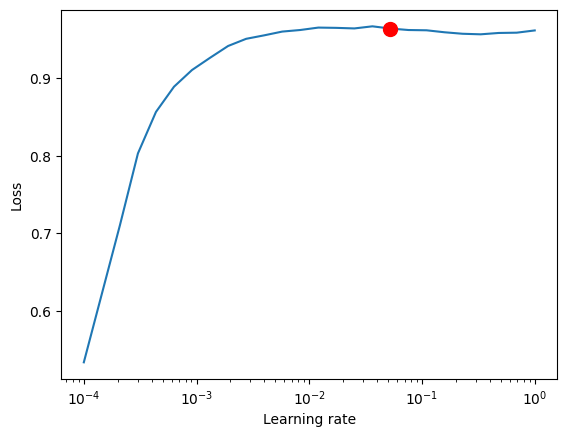

In [16]:
from lightning.pytorch.tuner import Tuner

# Create a Tuner
tuner = Tuner(trainer)

# Finding the learning rate
lr_finder =tuner.lr_find(model,datamodule=data_module, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs,attr_name='learning_rate')

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [17]:
model.best_lr = new_lr

In [18]:
model.learning_rate = config.learning_rate

In [19]:
trainer.fit(model=model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | UNet               | 121 K  | train
1 | train_acc     | MulticlassAccuracy | 0      | train
2 | valid_acc     | MulticlassAccuracy | 0      | train
3 | loss_function | CrossEntropyLoss   | 0      | train
-------------------------------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.486     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | UNet               | 121 K  | train
1 | train_acc     | MulticlassAccuracy | 0      | train
2 | valid_acc     | MulticlassAccuracy | 0      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


 Epoch: 0 | Val Loss: 1.02531 | Val Acc: 0.58356


Training: |          | 0/? [00:00<?, ?it/s]


 Epoch: 0 | Train Loss: 0.85648 | Train Acc: 0.61316

 Epoch: 1 | Train Loss: 0.73369 | Train Acc: 0.68694


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 276: 'val_loss' reached 1.31321 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=02-val_loss=1.31-val_loss=1.313213.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 276: 'val_loss' reached 1.31321 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=02-val_loss=1.31-val_loss=1.313213.ckpt' as top 3



 Epoch: 2 | Val Loss: 1.31321 | Val Acc: 0.59373

 Epoch: 2 | Train Loss: 0.71521 | Train Acc: 0.70732

 Epoch: 3 | Train Loss: 0.69601 | Train Acc: 0.72546

 Epoch: 4 | Train Loss: 0.71798 | Train Acc: 0.71666


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 552: 'val_loss' reached 2.62346 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=05-val_loss=2.62-val_loss=2.623462.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 552: 'val_loss' reached 2.62346 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=05-val_loss=2.62-val_loss=2.623462.ckpt' as top 3



 Epoch: 5 | Val Loss: 2.62346 | Val Acc: 0.59364

 Epoch: 5 | Train Loss: 0.68514 | Train Acc: 0.73830

 Epoch: 6 | Train Loss: 0.67829 | Train Acc: 0.74119

 Epoch: 7 | Train Loss: 0.66809 | Train Acc: 0.74581


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 828: 'val_loss' reached 2.57007 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=08-val_loss=2.57-val_loss=2.570073.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 828: 'val_loss' reached 2.57007 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=08-val_loss=2.57-val_loss=2.570073.ckpt' as top 3



 Epoch: 8 | Val Loss: 2.57007 | Val Acc: 0.59359

 Epoch: 8 | Train Loss: 0.64494 | Train Acc: 0.75557

 Epoch: 9 | Train Loss: 0.63075 | Train Acc: 0.76074

 Epoch: 10 | Train Loss: 0.62497 | Train Acc: 0.76265


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 1104: 'val_loss' reached 2.31314 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=11-val_loss=2.31-val_loss=2.313136.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 1104: 'val_loss' reached 2.31314 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=11-val_loss=2.31-val_loss=2.313136.ckpt' as top 3



 Epoch: 11 | Val Loss: 2.31314 | Val Acc: 0.59367

 Epoch: 11 | Train Loss: 0.60427 | Train Acc: 0.77011

 Epoch: 12 | Train Loss: 0.59906 | Train Acc: 0.77121

 Epoch: 13 | Train Loss: 0.59029 | Train Acc: 0.77618


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 1380: 'val_loss' reached 2.45883 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=14-val_loss=2.46-val_loss=2.458826.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 1380: 'val_loss' reached 2.45883 (best 1.31321), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=14-val_loss=2.46-val_loss=2.458826.ckpt' as top 3



 Epoch: 14 | Val Loss: 2.45883 | Val Acc: 0.59395

 Epoch: 14 | Train Loss: 0.57582 | Train Acc: 0.78099

 Epoch: 15 | Train Loss: 0.56150 | Train Acc: 0.78510

 Epoch: 16 | Train Loss: 0.56333 | Train Acc: 0.78510


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 1656: 'val_loss' was not in top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 1656: 'val_loss' was not in top 3



 Epoch: 17 | Val Loss: 2.96464 | Val Acc: 0.59472

 Epoch: 17 | Train Loss: 0.55106 | Train Acc: 0.78961

 Epoch: 18 | Train Loss: 0.54498 | Train Acc: 0.79249


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
